This notebook heavily refers to the following resources:
1. https://www.youtube.com/watch?v=viZrOnJclY0&ab_channel=StatQuestwithJoshStarmer
2. https://www.youtube.com/watch?v=Qf06XDYXCXI&t=1070s&ab_channel=StatQuestwithJoshStarmer

Word embedding is the process of converting a word into a vector that can be processed by a neural network. Unlike a tokenizer, where the input is simply being converted to a random token, the embedding process aims to create an embedded dictionary where words of similar meaning will be ``closer" when embedded into a vector. Words may also carry different meaning, therefore we hope to assign more than 1 number to describe different words. In this notebook, we are going to train our own word embedder using neural network. 

Consider the following training data
1. Fruits are tasty.
2. Cakes are tasty.

In our training data, there are a total of 4 unique words: fruits, are, tasty, cakes. Using the one hot encoding method, we can assign each unique words with a one vector, and the output of the word with another vector. 

Input:
1. fruits - [1, 0, 0, 0]
2. are    - [0, 1, 0, 0]
3. tasty  - [0, 0, 1, 0]
4. cakes  - [0, 0, 0, 1]

Label:
[0, 1, 0, 0]
[0, 0, 1, 0]
[0, 0, 0, 1]
[0, 1, 0, 0]

Lets try to create the input and label manually 


In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import torch
from torch import nn
from torch.optim import Adam
from torch.distributions.uniform import Uniform
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl
import pandas as pd
import matplotlib.pyplot as plt

inputs = torch.tensor([[1., 0., 0., 0.],
                       [0., 1., 0., 0.],
                       [0., 0., 1., 0.],
                       [0., 0., 0., 1.]])

labels = torch.tensor([[0., 1., 0., 0.],
                       [0., 0., 1., 0.],
                       [0., 0., 0., 1.],
                       [0., 1., 0., 0.]])

dataset = torch.utils.data.TensorDataset(inputs, labels)
dataloader = torch.utils.data.DataLoader(dataset)

Let's create a neural network. We need to initialize the weight matrix, loss function, forward feed, and the backward propagation optimizer. 

In [2]:
class WordEmbedding(pl.LightningModule):
    def __init__(self):
        super().__init__() #this is for lightning module
        min_value = -0.5
        max_value = 0.5

        #initialize the weight for network with 2 nodes
        self.input1_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input1_w2 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input2_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input2_w2 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input3_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input3_w2 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input4_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input4_w2 = nn.Parameter(Uniform(min_value, max_value).sample())

        self.output1_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output1_w2 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output2_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output2_w2 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output3_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output3_w2 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output4_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output4_w2 = nn.Parameter(Uniform(min_value, max_value).sample())

        #define loss function
        self.loss = nn.CrossEntropyLoss()

    def forward(self, input):
        #one-hot encodding
        #print(input)
        input = input[0] #make it into a vector instead of a tensor
        inputs_to_1st_hidden = ((input[0] * self.input1_w1) + 
                                (input[1] * self.input2_w1) +
                                (input[2] * self.input3_w1) +
                                (input[3] * self.input4_w1))
        inputs_to_2nd_hidden = ((input[0] * self.input1_w1) +
                                (input[1] * self.input2_w2) +
                                (input[2] * self.input3_w2) +
                                (input[3] * self.input4_w2))
        output1 = ((inputs_to_1st_hidden * self.output1_w1) +
                   (inputs_to_2nd_hidden *self.output1_w2))
        output2 = ((inputs_to_1st_hidden * self.output2_w1) +
                   (inputs_to_2nd_hidden *self.output2_w2))
        output3 = ((inputs_to_1st_hidden * self.output3_w1) +
                   (inputs_to_2nd_hidden *self.output3_w2))
        output4 = ((inputs_to_1st_hidden * self.output4_w1) +
                   (inputs_to_2nd_hidden *self.output4_w2))

        output_presoftmax = torch.stack([output1, output2, output3, output4])
        return(output_presoftmax)

    def configure_optimizers(self):
        return Adam(self.parameters(), lr = 0.1)

    def training_step(self,batch, batch_idx):
        input_i, label_i = batch
        output_i = self.forward(input_i)
        loss = self.loss(output_i, label_i[0])
        return loss
        

In [3]:
smallmodel = WordEmbedding()
print('Before parameterization, the parameters are :')
for name, param in smallmodel.named_parameters():
    print(name, param.data)      

Before parameterization, the parameters are :
input1_w1 tensor(-0.3755)
input1_w2 tensor(0.1837)
input2_w1 tensor(-0.2969)
input2_w2 tensor(0.3103)
input3_w1 tensor(0.4035)
input3_w2 tensor(0.2252)
input4_w1 tensor(-0.0282)
input4_w2 tensor(0.4423)
output1_w1 tensor(-0.1107)
output1_w2 tensor(0.2578)
output2_w1 tensor(-0.1416)
output2_w2 tensor(-0.0090)
output3_w1 tensor(-0.3146)
output3_w2 tensor(-0.0452)
output4_w1 tensor(0.2867)
output4_w2 tensor(-0.0495)


We are going to visualize the data before training, and the weight assigned to each token. Since the weight are randomly assigned, the word fruits and cakes should have weights that are not that similar. This is fine, since the goal is to train the weight parameters such that the weight for both fruits and cakes are similar. 

         w1        w2   token   input
0 -0.375475  0.183653  Fruits  input1
1 -0.296855  0.310268     are  input2
2  0.403518  0.225171   tasty  input3
3 -0.028202  0.442283   Cakes  input4


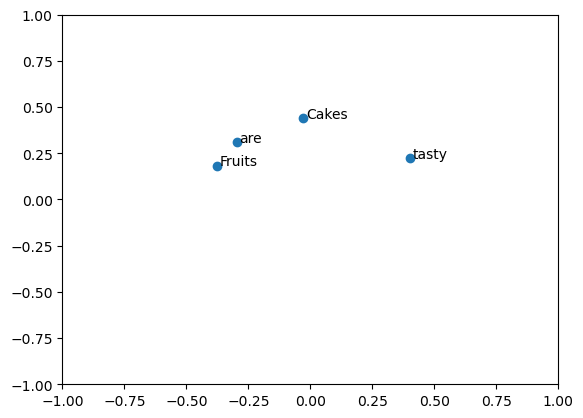

In [4]:
#graphing the data

#put the weight into dictionary
data = {'w1': [smallmodel.input1_w1.item(),
               smallmodel.input2_w1.item(),
               smallmodel.input3_w1.item(),
               smallmodel.input4_w1.item()],
        'w2': [smallmodel.input1_w2.item(),
               smallmodel.input2_w2.item(),
               smallmodel.input3_w2.item(),
               smallmodel.input4_w2.item(),],
        'token' : ["Fruits", "are", "tasty", "Cakes"],
        'input' : ['input1', 'input2', 'input3', 'input4']
       }

df = pd.DataFrame(data)
plt.scatter(df.w1, df.w2)
plt.text(df.w1[0] + 0.01, df.w2[0] , df.token[0])
plt.text(df.w1[1] + 0.01, df.w2[1] , df.token[1])
plt.text(df.w1[2] + 0.01, df.w2[2] , df.token[2])
plt.text(df.w1[3] + 0.01, df.w2[3] , df.token[3])
plt.xlim([-1, 1])
plt.ylim([-1, 1])
print(df)

Lets start training the neural network. We can perform trial and error to choose the number of epochs that return the best result. 

In [16]:
# training the neural network
trainer = pl.Trainer(max_epochs = 100)
trainer.fit(smallmodel, train_dataloaders = dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type             | Params
--------------------------------------------------
0 | loss         | CrossEntropyLoss | 0     
  | other params | n/a              | 16    
--------------------------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)
C:\Users\honlin\Anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\Users\honlin\Anaconda3\lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_ste

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=100` reached.


Let's replot the weight for each input. This time, we expect the word fruits and cakes to have a similar weight. 

         w1        w2   token   input
0 -3.239099  0.183653  Fruits  input1
1 -3.186517  3.318723     are  input2
2  3.507653  2.728766   tasty  input3
3 -3.164286 -3.110572   Cakes  input4


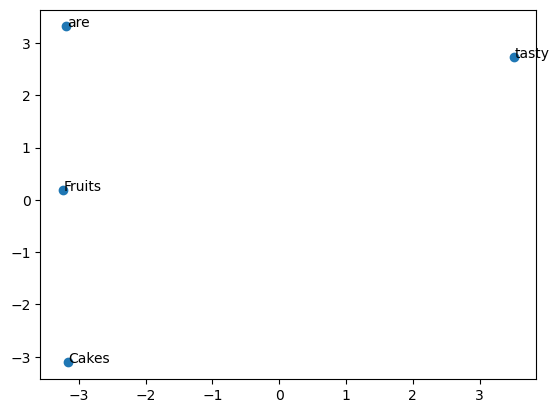

In [17]:
data = {'w1': [smallmodel.input1_w1.item(),
               smallmodel.input2_w1.item(),
               smallmodel.input3_w1.item(),
               smallmodel.input4_w1.item()],
        'w2': [smallmodel.input1_w2.item(),
               smallmodel.input2_w2.item(),
               smallmodel.input3_w2.item(),
               smallmodel.input4_w2.item(),],
        'token' : ["Fruits", "are", "tasty", "Cakes"],
        'input' : ['input1', 'input2', 'input3', 'input4']
       }

df = pd.DataFrame(data)

plt.scatter(df.w1, df.w2)
plt.text(df.w1[0] + 0.01, df.w2[0] , df.token[0])
plt.text(df.w1[1] + 0.01, df.w2[1] , df.token[1])
plt.text(df.w1[2] + 0.01, df.w2[2] , df.token[2])
plt.text(df.w1[3] + 0.01, df.w2[3] , df.token[3])
print(df)


Let's try to clean up the code. Instead of defining the weight one by one, we are going to use the nn.Linear() function. nn.Linear applies a linear operation to the input as such:
$y = xW^T + b$

In [12]:
class WordEmbeddinglinear(pl.LightningModule):
    def __init__(self):
        super().__init__() #this is the parent class for lightning module
        self.input_to_hidden = nn.Linear(in_features = 4, out_features = 2, bias = False)
        self.hidden_to_output = nn.Linear(in_features = 2, out_features = 4, bias = False)

        self.loss = nn.CrossEntropyLoss()

    def forward(self, input):
        hidden = self.input_to_hidden(input)  #save the sum from the first node to hidden
        output_values = self.hidden_to_output(hidden)
        return(output_values)

    def configure_optimizers(self):
        return Adam(self.parameters(), lr = 0.1)

    def training_step(self,batch, batch_idx):
        input_i, label_i = batch
        output_i = self.forward(input_i)
        loss = self.loss(output_i, label_i[0])
        return loss
        

         w1        w2   token   input
0  0.172023  0.435522  Fruits  input1
1 -0.347771  0.066010     are  input2
2  0.138607  0.438607   tasty  input3
3 -0.356824 -0.243367   Cakes  input4


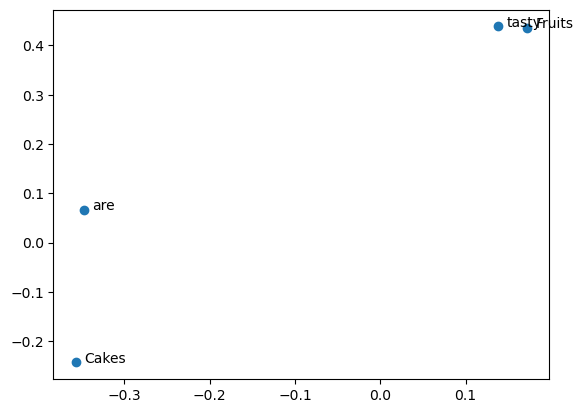

In [9]:
modelLinear = WordEmbeddinglinear()
data = {
    'w1' : modelLinear.input_to_hidden.weight.detach()[0].numpy(),
    'w2' : modelLinear.input_to_hidden.weight.detach()[1].numpy(),
    'token' : ["Fruits", "are", "tasty", "Cakes"],
    'input' : ['input1', 'input2', 'input3', 'input4']
}

df = pd.DataFrame(data)
plt.scatter(df.w1, df.w2)
plt.text(df.w1[0] + 0.01, df.w2[0] , df.token[0])
plt.text(df.w1[1] + 0.01, df.w2[1] , df.token[1])
plt.text(df.w1[2] + 0.01, df.w2[2] , df.token[2])
plt.text(df.w1[3] + 0.01, df.w2[3] , df.token[3])
print(df)


In [14]:
# training the neural network
trainer = pl.Trainer(max_epochs = 100)
trainer.fit(smallmodel, train_dataloaders = dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type             | Params
--------------------------------------------------
0 | loss         | CrossEntropyLoss | 0     
  | other params | n/a              | 16    
--------------------------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)
C:\Users\honlin\Anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\Users\honlin\Anaconda3\lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_ste

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=100` reached.


         w1        w2   token   input
0 -0.104894 -0.372201  Fruits  input1
1 -0.467462  0.437790     are  input2
2 -0.072161  0.442254   tasty  input3
3  0.096490 -0.373144   Cakes  input4


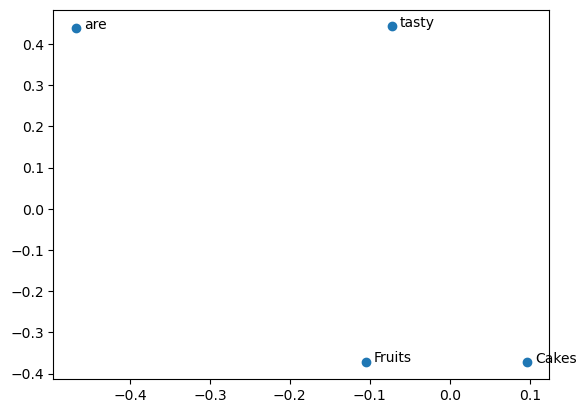

In [15]:
modelLinear = WordEmbeddinglinear()
data = {
    'w1' : modelLinear.input_to_hidden.weight.detach()[0].numpy(),
    'w2' : modelLinear.input_to_hidden.weight.detach()[1].numpy(),
    'token' : ["Fruits", "are", "tasty", "Cakes"],
    'input' : ['input1', 'input2', 'input3', 'input4']
}

df = pd.DataFrame(data)
plt.scatter(df.w1, df.w2)
plt.text(df.w1[0] + 0.01, df.w2[0] , df.token[0])
plt.text(df.w1[1] + 0.01, df.w2[1] , df.token[1])
plt.text(df.w1[2] + 0.01, df.w2[2] , df.token[2])
plt.text(df.w1[3] + 0.01, df.w2[3] , df.token[3])
print(df)